In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, recall_score,precision_score
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline,Pipeline

In [2]:
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:0","/gpu:1"],
                                                   cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
# Pour jupyter-notebook
games_data = pd.read_csv('nba_games_data.csv', sep=';')

In [5]:
# Pour Google colab
# players_data = pd.read_csv('nba_player_stats_data.csv', sep=';')

### Games Data

In [6]:
games_data.shape
games_data.head()

,game_id,date_game,game_start_time,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,...,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls,overtimes,attendance,game_remarks
0,b67f10f7-3459-45d3-b82e-65c6c2602441,"Tue, Dec 22, 2020",7:00p,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,...,44.0,57.0,24.0,11.0,7.0,20.0,22.0,NaN,0,NaN
1,9cdcac86-1ec3-4ce3-b6a7-2496b64011b3,"Tue, Dec 22, 2020",10:00p,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,...,37.0,45.0,22.0,4.0,2.0,19.0,20.0,NaN,0,NaN
2,21c8f82e-3a7c-4e79-95ef-83290a1f9bd4,"Wed, Dec 23, 2020",7:00p,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,...,40.0,50.0,34.0,12.0,3.0,18.0,22.0,NaN,300,NaN
3,4209ddff-3f77-490b-a68d-2929fc99e334,"Wed, Dec 23, 2020",7:00p,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,...,40.0,50.0,28.0,6.0,9.0,13.0,24.0,NaN,0,NaN
4,ec1db7f3-e052-47cf-9dc5-3feaf9a4345f,"Wed, Dec 23, 2020",7:00p,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,...,30.0,41.0,23.0,15.0,3.0,17.0,19.0,NaN,"3,396",NaN


In [7]:
games_data.columns

Index(['game_id', 'date_game', 'game_start_time', 'v_team_name', 'v_pts',
       'v_record', 'v_field_goals', 'v_field_goal_attempts',
       'v_field_goal_percentage', 'v_three_points_field_goals',
       'v_three_points_field_goal_attempts',
       'v_three_points_field_goal_percentage', 'v_free_throws',
       'v_free_throw_attempts', 'v_free_throw_percentage',
       'v_offensive_rebounds', 'v_defensive_rebounds', 'v_total_rebounds',
       'v_assists', 'v_steals', 'v_blocks', 'v_turn_over', 'v_personnal_fouls',
       'h_team_name', 'h_pts', 'h_record', 'h_field_goals',
       'h_field_goal_attempts', 'h_field_goal_percentage',
       'h_three_points_field_goals', 'h_three_points_field_goal_attempts',
       'h_three_points_field_goal_percentage', 'h_free_throws',
       'h_free_throw_attempts', 'h_free_throw_percentage',
       'h_offensive_rebounds', 'h_defensive_rebounds', 'h_total_rebounds',
       'h_assists', 'h_steals', 'h_blocks', 'h_turn_over', 'h_personnal_fouls',
      

In [8]:
games_data.describe()

,v_pts,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,v_free_throw_attempts,v_free_throw_percentage,...,h_free_throw_attempts,h_free_throw_percentage,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls
count,30073.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,...,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000,30072.000000
mean,98.450271,36.736632,82.280793,0.447339,7.094640,20.148144,0.347606,17.882981,23.685555,0.755741,...,24.719407,0.758114,11.370677,31.836027,43.206704,22.695464,7.667764,5.204742,13.717844,20.880919
std,13.122621,5.323683,7.979687,0.055589,3.911123,8.850825,0.118401,6.135830,7.579191,0.103255,...,7.908892,0.100052,4.089107,5.480256,6.602620,5.210258,2.957086,2.690579,3.858583,4.457062
min,53.000000,16.000000,55.000000,0.239000,0.000000,1.000000,0.000000,1.000000,1.000000,0.143000,...,1.000000,0.143000,1.000000,13.000000,17.000000,5.000000,0.000000,0.000000,1.000000,6.000000
25%,89.000000,33.000000,77.000000,0.410000,4.000000,14.000000,0.273000,14.000000,18.000000,0.690000,...,19.000000,0.696000,8.000000,28.000000,39.000000,19.000000,6.000000,3.000000,11.000000,18.000000
50%,98.000000,37.000000,82.000000,0.446000,7.000000,19.000000,0.348000,17.000000,23.000000,0.762000,...,24.000000,0.765000,11.000000,32.000000,43.000000,22.000000,7.000000,5.000000,14.000000,21.000000
75%,107.000000,40.000000,87.000000,0.484000,9.000000,25.000000,0.423000,22.000000,28.000000,0.826000,...,30.000000,0.826000,14.000000,35.000000,48.000000,26.000000,10.000000,7.000000,16.000000,24.000000
max,168.000000,63.000000,129.000000,0.674000,29.000000,63.000000,1.000000,52.000000,64.000000,1.000000,...,64.000000,1.000000,33.000000,55.000000,72.000000,50.000000,22.000000,23.000000,30.000000,45.000000


In [9]:
v_teams =  games_data['v_team_name'].unique()
h_teams =  games_data['h_team_name'].unique()

teams = np.concatenate([v_teams, h_teams])
teams = np.unique(teams)

In [10]:
teams

array(['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets',
       'Charlotte Bobcats', 'Charlotte Hornets', 'Chicago Bulls',
       'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets',
       'Detroit Pistons', 'Golden State Warriors', 'Houston Rockets',
       'Indiana Pacers', 'Los Angeles Clippers', 'Los Angeles Lakers',
       'Memphis Grizzlies', 'Miami Heat', 'Milwaukee Bucks',
       'Minnesota Timberwolves', 'New Jersey Nets', 'New Orleans Hornets',
       'New Orleans Pelicans', 'New Orleans/Oklahoma City Hornets',
       'New York Knicks', 'Oklahoma City Thunder', 'Orlando Magic',
       'Philadelphia 76ers', 'Phoenix Suns', 'Portland Trail Blazers',
       'Sacramento Kings', 'San Antonio Spurs', 'Seattle SuperSonics',
       'Toronto Raptors', 'Utah Jazz', 'Vancouver Grizzlies',
       'Washington Wizards'], dtype=object)

In [11]:
len(teams)

36

In [12]:
games_data_clean = games_data.drop(columns=['game_id', 'date_game', 'game_start_time', 'game_remarks', 'attendance', 'overtimes'])
games_data_clean

,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,...,h_free_throw_attempts,h_free_throw_percentage,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,...,32.0,0.813,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,...,31.0,0.774,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,...,20.0,0.750,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,...,29.0,0.724,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,...,30.0,0.633,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,...,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0
30071,Utah Jazz,54.0,01-f�vr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,...,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,...,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,...,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0


### Add column v_victory and h_vitory as boolean

In [13]:
v_victory = []
h_victory = []

for index, row in games_data_clean.iterrows():
    if row['v_pts'] > row['h_pts'] :
        v_victory.append(1)
        h_victory.append(0)
    else:
        h_victory.append(1)
        v_victory.append(0)

games_data_clean['v_victory'] = v_victory 
games_data_clean['h_victory'] = h_victory

In [14]:
games_data_clean

,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,...,h_offensive_rebounds,h_defensive_rebounds,h_total_rebounds,h_assists,h_steals,h_blocks,h_turn_over,h_personnal_fouls,v_victory,h_victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,...,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0,0,1
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,...,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0,1,0
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,...,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0,0,1
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,...,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0,0,1
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,...,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,...,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0,1,0
30071,Utah Jazz,54.0,01-f�vr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,...,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0,0,1
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,...,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0,0,1
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,...,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0,1,0


In [15]:
games_data_clean_visitor = games_data_clean.filter(regex='v_')
games_data_clean_home = games_data_clean.filter(regex='h_')

In [16]:
games_data_clean_visitor

,v_team_name,v_pts,v_record,v_field_goals,v_field_goal_attempts,v_field_goal_percentage,v_three_points_field_goals,v_three_points_field_goal_attempts,v_three_points_field_goal_percentage,v_free_throws,...,v_free_throw_percentage,v_offensive_rebounds,v_defensive_rebounds,v_total_rebounds,v_assists,v_steals,v_blocks,v_turn_over,v_personnal_fouls,v_victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,...,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,...,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,1
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,...,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,...,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,...,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,...,0.815,18.0,18.0,36.0,17.0,10.0,3.0,7.0,21.0,1
30071,Utah Jazz,54.0,01-f�vr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,...,0.786,9.0,29.0,38.0,16.0,7.0,3.0,26.0,26.0,0
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,...,0.667,13.0,27.0,40.0,24.0,6.0,1.0,10.0,32.0,0
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,...,0.778,11.0,26.0,37.0,24.0,10.0,3.0,16.0,24.0,1


In [17]:
visitor_columns = games_data_clean_visitor.columns
visitor_columns_rename = {}

for column in visitor_columns:
    visitor_columns_rename[column] = column[2:]
    
games_data_clean_visitor = games_data_clean_visitor.rename(columns=visitor_columns_rename)


In [18]:
games_data_clean_visitor

,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,...,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,...,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,...,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,1
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,...,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,...,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,...,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Chicago Bulls,93.0,01-janv,34.0,80.0,0.425,3.0,16.0,0.188,22.0,...,0.815,18.0,18.0,36.0,17.0,10.0,3.0,7.0,21.0,1
30071,Utah Jazz,54.0,01-f�vr,21.0,70.0,0.300,1.0,9.0,0.111,11.0,...,0.786,9.0,29.0,38.0,16.0,7.0,3.0,26.0,26.0,0
30072,Utah Jazz,82.0,01-mars,33.0,78.0,0.423,2.0,15.0,0.133,14.0,...,0.667,13.0,27.0,40.0,24.0,6.0,1.0,10.0,32.0,0
30073,Utah Jazz,83.0,02-mars,34.0,67.0,0.507,1.0,5.0,0.200,14.0,...,0.778,11.0,26.0,37.0,24.0,10.0,3.0,16.0,24.0,1


In [19]:
home_columns = games_data_clean_home.columns
home_columns_rename = {}

for column in home_columns:
    home_columns_rename[column] = column[2:]
    
games_data_clean_home = games_data_clean_home.rename(columns=home_columns_rename)

In [20]:
games_data_clean_home

,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,...,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
0,Brooklyn Nets,125.0,1-0,42.0,92.0,0.457,15.0,35.0,0.429,26.0,...,0.813,13.0,44.0,57.0,24.0,11.0,7.0,20.0,22.0,1
1,Los Angeles Lakers,109.0,0-1,38.0,81.0,0.469,9.0,29.0,0.310,24.0,...,0.774,8.0,37.0,45.0,22.0,4.0,2.0,19.0,20.0,0
2,Cleveland Cavaliers,121.0,1-0,46.0,87.0,0.529,14.0,30.0,0.467,15.0,...,0.750,10.0,40.0,50.0,34.0,12.0,3.0,18.0,22.0,1
3,Indiana Pacers,121.0,1-0,46.0,94.0,0.489,8.0,34.0,0.235,21.0,...,0.724,10.0,40.0,50.0,28.0,6.0,9.0,13.0,24.0,1
4,Orlando Magic,113.0,1-0,42.0,88.0,0.477,10.0,28.0,0.357,19.0,...,0.633,11.0,30.0,41.0,23.0,15.0,3.0,17.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,...,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0,0
30071,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,...,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0,1
30072,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,...,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0,1
30073,Chicago Bulls,81.0,03-f�vr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,...,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0,0


In [21]:
teams_stats = pd.concat([games_data_clean_visitor, games_data_clean_home])

In [22]:
teams_stats

,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,...,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,15.0,...,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0,0
1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,14.0,...,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0,1
2,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,8.0,...,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0,0
3,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,17.0,...,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0,0
4,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,16.0,...,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,15.0,...,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0,0
30071,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,18.0,...,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0,1
30072,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,27.0,...,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0,1
30073,Chicago Bulls,81.0,03-f�vr,29.0,75.0,0.387,7.0,20.0,0.350,16.0,...,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0,0


In [23]:
teams_stats_by_team_name = teams_stats.groupby('team_name').mean()
teams_stats_by_team_name

,pts,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls,victory
team_name,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,98.410500,36.666000,81.656500,0.449739,7.089000,20.154500,0.346430,17.989500,23.652000,0.760054,11.083000,30.973500,42.056500,21.682500,7.630500,4.900500,14.358500,20.725500,0.454500
Boston Celtics,99.771930,36.902323,81.755334,0.452642,7.788051,21.917022,0.352323,18.179232,23.741584,0.766676,10.421053,31.215268,41.636321,22.287340,8.366050,4.510669,14.107634,22.416785,0.538170
Brooklyn Nets,104.724734,38.378989,84.724734,0.454066,10.158245,28.663564,0.351468,17.808511,23.448138,0.760449,10.171543,33.301862,43.473404,22.547872,7.085106,4.410904,14.134309,20.093085,0.446809
Charlotte Bobcats,94.541872,35.333744,80.201970,0.441732,5.387931,15.582512,0.342869,18.486453,25.116995,0.734869,10.977833,29.477833,40.455665,21.025862,7.427340,5.096059,13.747537,21.052956,0.360837
Charlotte Hornets,100.396891,36.727461,82.933679,0.443948,7.866321,22.190674,0.350706,19.075648,25.020725,0.763638,10.664249,32.555440,43.219689,22.786528,7.561658,4.979275,12.959585,19.401036,0.499482
Chicago Bulls,96.863342,36.473317,82.680299,0.442042,6.457357,18.232918,0.350056,17.459352,23.195511,0.753606,11.743142,31.661347,43.404489,22.189027,7.423441,4.917706,14.237905,21.175062,0.462344
Cleveland Cavaliers,98.671059,36.612006,81.582723,0.449717,7.104929,19.832601,0.351267,18.342118,24.560761,0.746748,11.463153,31.162518,42.625671,21.546608,7.370913,4.608590,13.964861,20.920449,0.484139
Dallas Mavericks,102.190569,37.968872,83.347276,0.456464,8.076848,22.321984,0.362427,18.181907,23.046693,0.788643,10.719844,31.622082,42.341926,21.600195,7.311284,4.906128,12.541342,20.712062,0.565873
Denver Nuggets,102.618118,38.086086,83.865365,0.454775,7.099099,20.304805,0.341429,19.346847,25.739740,0.751730,11.910911,31.396396,43.307307,23.173173,7.979479,5.355355,14.297798,21.836336,0.498999


In [24]:
first_column = teams_stats.pop('victory')
  
# insert column using insert(position,column_name,
# first_column) function
teams_stats.insert(0, 'victory', first_column)

In [25]:
teams_stats

,victory,team_name,pts,record,field_goals,field_goal_attempts,field_goal_percentage,three_points_field_goals,three_points_field_goal_attempts,three_points_field_goal_percentage,...,free_throw_attempts,free_throw_percentage,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls
0,0,Golden State Warriors,99.0,0-1,37.0,99.0,0.374,10.0,33.0,0.303,...,23.0,0.652,13.0,34.0,47.0,26.0,6.0,6.0,18.0,24.0
1,1,Los Angeles Clippers,116.0,1-0,44.0,93.0,0.473,14.0,40.0,0.350,...,19.0,0.737,11.0,29.0,40.0,22.0,10.0,3.0,16.0,29.0
2,0,Charlotte Hornets,114.0,0-1,45.0,90.0,0.500,16.0,44.0,0.364,...,15.0,0.533,8.0,24.0,32.0,29.0,10.0,4.0,15.0,17.0
3,0,New York Knicks,107.0,0-1,39.0,85.0,0.459,12.0,28.0,0.429,...,23.0,0.739,5.0,35.0,40.0,25.0,8.0,8.0,16.0,27.0
4,0,Miami Heat,107.0,0-1,42.0,83.0,0.506,7.0,20.0,0.350,...,19.0,0.842,7.0,36.0,43.0,25.0,11.0,2.0,22.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,0,Utah Jazz,88.0,01-janv,33.0,67.0,0.493,7.0,13.0,0.538,...,19.0,0.789,9.0,29.0,38.0,22.0,3.0,5.0,19.0,28.0
30071,1,Chicago Bulls,96.0,02-janv,37.0,76.0,0.487,4.0,11.0,0.364,...,26.0,0.692,11.0,39.0,50.0,25.0,13.0,5.0,17.0,19.0
30072,1,Chicago Bulls,86.0,03-janv,27.0,73.0,0.370,5.0,15.0,0.333,...,40.0,0.675,17.0,27.0,44.0,18.0,7.0,2.0,9.0,19.0
30073,0,Chicago Bulls,81.0,03-f�vr,29.0,75.0,0.387,7.0,20.0,0.350,...,20.0,0.800,13.0,20.0,33.0,19.0,11.0,5.0,16.0,25.0


In [26]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    


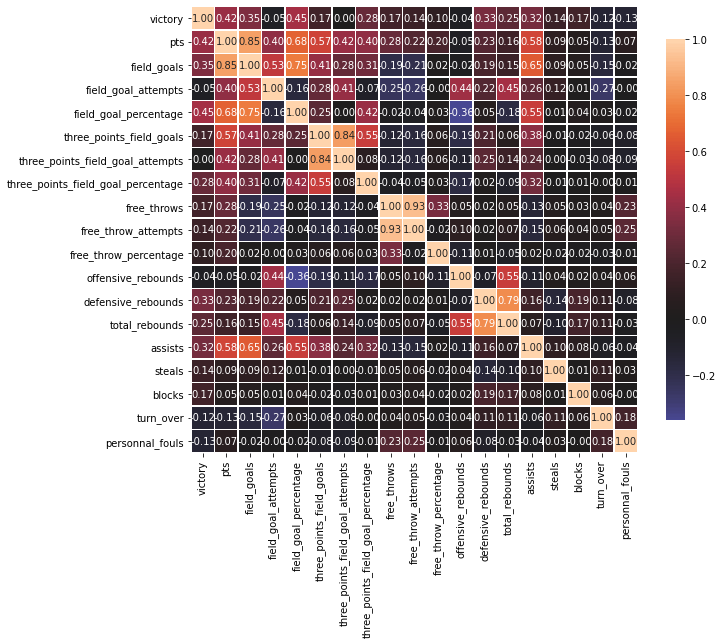

In [27]:
correlation_heatmap(teams_stats)

In [28]:
# plt.figure(figsize=(15,15))
# sns.heatmap(teams_stats.corr())
# plt.title('Correlation in the data')
# plt.show()

In [29]:
corrMatrix = teams_stats.corr()
corrMatrix['victory'].sort_values(ascending=False) 

victory                               1.000000
field_goal_percentage                 0.445418
pts                                   0.416591
field_goals                           0.348003
defensive_rebounds                    0.331635
assists                               0.324453
three_points_field_goal_percentage    0.283801
total_rebounds                        0.252551
free_throws                           0.171574
three_points_field_goals              0.169380
blocks                                0.167855
free_throw_attempts                   0.143018
steals                                0.141243
free_throw_percentage                 0.100031
three_points_field_goal_attempts      0.001597
offensive_rebounds                   -0.039701
field_goal_attempts                  -0.052758
turn_over                            -0.122421
personnal_fouls                      -0.129532
Name: victory, dtype: float64

In [30]:
# corrMatrix['victory'].sort_values(ascending=False) < 0.1 or corrMatrix['victory'].sort_values(ascending=False) < -0.1

In [31]:
# df = teams_stats.loc[corrMatrix['victory'].sort_values(ascending=False) < 0]
# df

# teams_stats[corrMatrix['victory'].sort_values(ascending=False) < 0]

In [32]:
teams_stats = teams_stats.drop(columns=['offensive_rebounds', 'field_goal_attempts', 'three_points_field_goal_attempts'])

In [33]:
teams_stats = teams_stats.drop(columns=['team_name', 'record'])

In [34]:
teams_stats

,victory,pts,field_goals,field_goal_percentage,three_points_field_goals,three_points_field_goal_percentage,free_throws,free_throw_attempts,free_throw_percentage,defensive_rebounds,total_rebounds,assists,steals,blocks,turn_over,personnal_fouls
0,0,99.0,37.0,0.374,10.0,0.303,15.0,23.0,0.652,34.0,47.0,26.0,6.0,6.0,18.0,24.0
1,1,116.0,44.0,0.473,14.0,0.350,14.0,19.0,0.737,29.0,40.0,22.0,10.0,3.0,16.0,29.0
2,0,114.0,45.0,0.500,16.0,0.364,8.0,15.0,0.533,24.0,32.0,29.0,10.0,4.0,15.0,17.0
3,0,107.0,39.0,0.459,12.0,0.429,17.0,23.0,0.739,35.0,40.0,25.0,8.0,8.0,16.0,27.0
4,0,107.0,42.0,0.506,7.0,0.350,16.0,19.0,0.842,36.0,43.0,25.0,11.0,2.0,22.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30070,0,88.0,33.0,0.493,7.0,0.538,15.0,19.0,0.789,29.0,38.0,22.0,3.0,5.0,19.0,28.0
30071,1,96.0,37.0,0.487,4.0,0.364,18.0,26.0,0.692,39.0,50.0,25.0,13.0,5.0,17.0,19.0
30072,1,86.0,27.0,0.370,5.0,0.333,27.0,40.0,0.675,27.0,44.0,18.0,7.0,2.0,9.0,19.0
30073,0,81.0,29.0,0.387,7.0,0.350,16.0,20.0,0.800,20.0,33.0,19.0,11.0,5.0,16.0,25.0


In [35]:
corrMatrix = teams_stats.corr()
corrMatrix['victory'].sort_values(ascending=False) 

victory                               1.000000
field_goal_percentage                 0.445418
pts                                   0.416591
field_goals                           0.348003
defensive_rebounds                    0.331635
assists                               0.324453
three_points_field_goal_percentage    0.283801
total_rebounds                        0.252551
free_throws                           0.171574
three_points_field_goals              0.169380
blocks                                0.167855
free_throw_attempts                   0.143018
steals                                0.141243
free_throw_percentage                 0.100031
turn_over                            -0.122421
personnal_fouls                      -0.129532
Name: victory, dtype: float64

In [36]:
X = teams_stats['victory']
Y = teams_stats['field_goal_percentage']

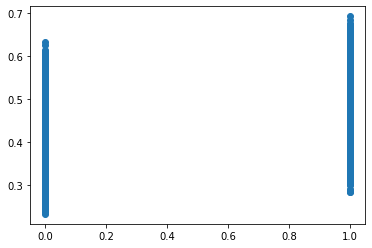

In [37]:
plt.scatter(X,Y)
plt.show()

### Il y a des valeurs manquantes

In [38]:
print("Nombre de valeurs nulles : " + str(teams_stats.isnull().sum().sum()))

Nombre de valeurs nulles : 89


In [39]:
teams_stats.isna().sum()

victory                               0
pts                                   4
field_goals                           6
field_goal_percentage                 6
three_points_field_goals              6
three_points_field_goal_percentage    7
free_throws                           6
free_throw_attempts                   6
free_throw_percentage                 6
defensive_rebounds                    6
total_rebounds                        6
assists                               6
steals                                6
blocks                                6
turn_over                             6
personnal_fouls                       6
dtype: int64

In [40]:
teams_stats = teams_stats.dropna()

In [41]:
print("Nombre de valeurs nulles : " + str(teams_stats.isnull().sum().sum()))

Nombre de valeurs nulles : 0


In [42]:
# plt.figure(figsize=(4,8))
# colors = ["0", "1"]
# sns.countplot(x=teams_stats['victory'], palette = "Set2")
# plt.title('Stars Distribution \n (0: Match perdus || 1: Matchs gagnés)', fontsize=14)

## Test d'algo

In [43]:
from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(teams_stats, test_size=0.2)

In [44]:
# len(train_data)

In [45]:
# len(test_data)

In [46]:
# X_train = train_data.drop(["victory"],axis=1)
# y_train = train_data["victory"]   
# X_test = test_data.drop(["victory"],axis=1)
# y_test = test_data["victory"]

In [47]:
X = teams_stats.drop('victory', axis=1)  
y = teams_stats['victory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#### Normalize

In [48]:
X_train = normalize(X_train)
X_test = normalize(X_test)

#### Feature scaling

In [49]:
std_scaler = StandardScaler()
X_train = scaled = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

### Les modèles

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Decision tree

In [51]:
model_DT = DecisionTreeClassifier(random_state=1)

In [52]:
model_DT.fit(X_train, y_train)
print(model_DT.__class__.__name__, model_DT.score(X_test, y_test))
print(confusion_matrix(y_test, model_DT.predict(X_test)))

DecisionTreeClassifier 0.6389558566796908
[[3855 2173]
 [2170 3831]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

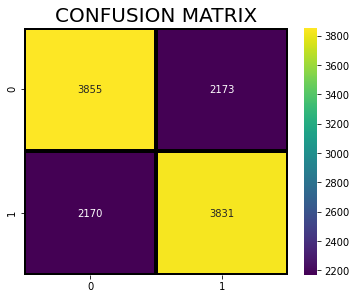

In [53]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_DT.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## KNN

In [54]:
model_KNN = KNeighborsClassifier(n_jobs=-1)

In [55]:
model_KNN.fit(X_train, y_train)
print(model_KNN.__class__.__name__, model_KNN.score(X_test, y_test))
print(confusion_matrix(y_test, model_KNN.predict(X_test)))

KNeighborsClassifier 0.6766979798819519
[[3903 2125]
 [1764 4237]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

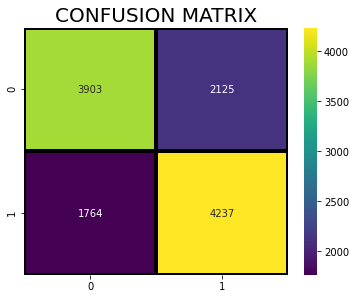

In [56]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_KNN.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Random Forest

In [57]:
model_RF = RandomForestClassifier(n_jobs=-1)

In [58]:
model_RF.fit(X_train, y_train)
print(model_RF.__class__.__name__, model_RF.score(X_test, y_test))
print(confusion_matrix(y_test, model_RF.predict(X_test)))

RandomForestClassifier 0.7339762241250312
[[4484 1544]
 [1656 4345]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

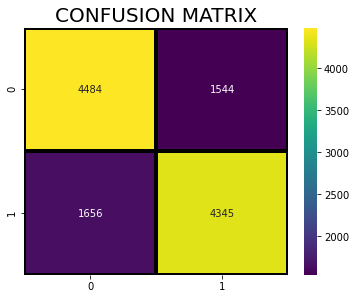

In [59]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Regression

In [60]:
model_LR = LogisticRegression(n_jobs=-1)

In [61]:
model_LR.fit(X_train, y_train)
print(model_LR.__class__.__name__, model_LR.score(X_test, y_test))
print(confusion_matrix(y_test, model_LR.predict(X_test)))

LogisticRegression 0.8090448083797489
[[4816 1212]
 [1085 4916]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

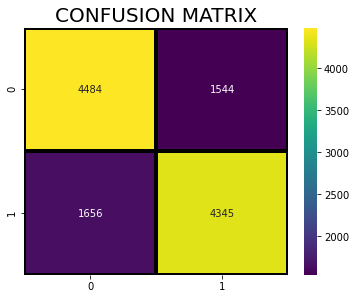

In [62]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Support Vector Machine

In [63]:
model_SVC = SVC()

In [64]:
model_SVC.fit(X_train, y_train)
print(model_SVC.__class__.__name__, model_SVC.score(X_test, y_test))
print(confusion_matrix(y_test, model_SVC.predict(X_test)))

SVC 0.8289965915703716
[[5020 1008]
 [1049 4952]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

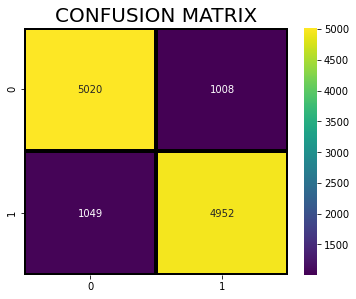

In [65]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_SVC.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#### Trop lent !

In [66]:
# kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
# def getClassifier(ktype):
#     if ktype == 0:
#         # Polynomial kernal
#         return SVC(kernel='poly', degree=8, gamma="auto")
#     elif ktype == 1:
#         # Radial Basis Function kernal
#         return SVC(kernel='rbf', gamma="auto")
#     elif ktype == 2:
#         # Sigmoid kernal
#         return SVC(kernel='sigmoid', gamma="auto")
#     elif ktype == 3:
#         # Linear kernal
#         return SVC(kernel='linear', gamma="auto")

# for i in range(2):
#     # Separate data into test and training sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)# Train a SVC model using different kernal
#     svclassifier = getClassifier(i) 
#     svclassifier.fit(X_train, y_train)# Make prediction
#     y_pred = svclassifier.predict(X_test)# Evaluate our model
#     print("Evaluation:", kernals[i], "kernel")
#     print(classification_report(y_test,y_pred))

In [67]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [68]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
# grid.fit(X_train,y_train)

In [69]:
# print(grid.best_estimator_)

In [70]:
# grid_predictions = grid.predict(X_test)
# print(confusion_matrix(y_test,grid_predictions))
# print(classification_report(y_test,grid_predictions))#Output

#### On essaye le linearSVC

In [79]:
model_SVC = LinearSVC(random_state=0, tol=1e-5)

In [80]:
model_SVC.fit(X_train, y_train)
print(model_SVC.__class__.__name__, model_SVC.score(X_test, y_test))
print(confusion_matrix(y_test, model_SVC.predict(X_test)))

LinearSVC 0.8094604705295536
[[4814 1214]
 [1078 4923]]


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Text(0.5, 1.0, 'CONFUSION MATRIX')

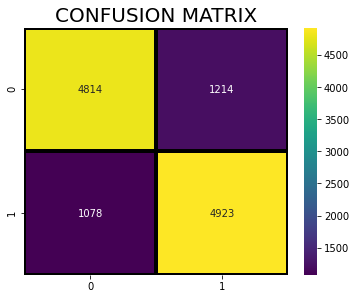

In [81]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_SVC.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#### Mieux mais moins efficace

## GridSearchCV

### Logistic regression

In [102]:
param_grid={'penalty': ['none', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
      
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..............................C=0.001, penalty=none; total time=   0.0s
[CV] END ..............................C=0.001, penalty=none; total time=   0.0s
[CV] END ..............................C=0.001, penalty=none; total time=   0.0s
[CV] END ..............................C=0.001, penalty=none; total time=   0.0s


d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............................C=0.001, penalty=none; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ..............................C=0.009, penalty=none; total time=   0.0s


d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............................C=0.009, penalty=none; total time=   0.0s
[CV] END ..............................C=0.009, penalty=none; total time=   0.0s
[CV] END ..............................C=0.009, penalty=none; total time=   0.0s
[CV] END ..............................C=0.009, penalty=none; total time=   0.0s
[CV] END ................................C=0.009, penalty=l2; total time=   0.0s
[CV] END ................................C=0.009, penalty=l2; total time=   0.0s
[CV] END ................................C=0.009, penalty=l2; total time=   0.0s
[CV] END ................................C=0.009, penalty=l2; total time=   0.0s
[CV] END ................................C=0.009, penalty=l2; total time=   0.0s
[CV] END ...............................C=0.01, penalty=none; total time=   0.0s


d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............................C=0.01, penalty=none; total time=   0.0s
[CV] END ...............................C=0.01, penalty=none; total time=   0.0s
[CV] END ...............................C=0.01, penalty=none; total time=   0.0s
[CV] END ...............................C=0.01, penalty=none; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ...............................C=0.09, penalty=none; total time=   0.0s
[CV] END ...............................C=0.09, penalty=none; total time=   0.0s


d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............................C=0.09, penalty=none; total time=   0.0s
[CV] END ...............................C=0.09, penalty=none; total time=   0.0s
[CV] END ...............................C=0.09, penalty=none; total time=   0.0s
[CV] END .................................C=0.09, penalty=l2; total time=   0.0s
[CV] END .................................C=0.09, penalty=l2; total time=   0.0s
[CV] END .................................C=0.09, penalty=l2; total time=   0.0s
[CV] END .................................C=0.09, penalty=l2; total time=   0.0s
[CV] END .................................C=0.09, penalty=l2; total time=   0.0s
[CV] END ..................................C=1, penalty=none; total time=   0.0s
[CV] END ..................................C=1, penalty=none; total time=   0.0s
[CV] END ..................................C=1, penalty=none; total time=   0.0s
[CV] END ..................................C=1, penalty=none; total time=   0.0s
[CV] END ...................

d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................................C=5, penalty=none; total time=   0.0s
[CV] END ..................................C=5, penalty=none; total time=   0.0s
[CV] END ..................................C=5, penalty=none; total time=   0.0s
[CV] END ....................................C=5, penalty=l2; total time=   0.0s
[CV] END ....................................C=5, penalty=l2; total time=   0.0s
[CV] END ....................................C=5, penalty=l2; total time=   0.0s
[CV] END ....................................C=5, penalty=l2; total time=   0.0s
[CV] END ....................................C=5, penalty=l2; total time=   0.0s
[CV] END .................................C=10, penalty=none; total time=   0.0s
[CV] END .................................C=10, penalty=none; total time=   0.0s


d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................................C=10, penalty=none; total time=   0.0s
[CV] END .................................C=10, penalty=none; total time=   0.0s
[CV] END .................................C=10, penalty=none; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.0s
[CV] END .................................C=25, penalty=none; total time=   0.0s
[CV] END .................................C=25, penalty=none; total time=   0.0s


d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\machine_learning_3.8\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................................C=25, penalty=none; total time=   0.0s
[CV] END .................................C=25, penalty=none; total time=   0.0s
[CV] END .................................C=25, penalty=none; total time=   0.0s
[CV] END ...................................C=25, penalty=l2; total time=   0.0s
[CV] END ...................................C=25, penalty=l2; total time=   0.0s
[CV] END ...................................C=25, penalty=l2; total time=   0.0s
[CV] END ...................................C=25, penalty=l2; total time=   0.0s
[CV] END ...................................C=25, penalty=l2; total time=   0.0s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['none', 'l2']},
             verbose=2)

In [103]:
print(grid.best_estimator_)

LogisticRegression(C=5)


In [104]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[4816 1212]
 [1086 4915]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6028
           1       0.80      0.82      0.81      6001

    accuracy                           0.81     12029
   macro avg       0.81      0.81      0.81     12029
weighted avg       0.81      0.81      0.81     12029



### Random Forest

In [107]:
rfc=RandomForestClassifier(random_state=42)

In [124]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [126]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=2)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   5.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   5.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   5.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   5.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   5.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=  14.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=  14.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=  14.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=  14.8s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=  14.9

[CV] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500; total time=  20.8s
[CV] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500; total time=  20.8s
[CV] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500; total time=  21.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200; total time=   9.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200; total time=   9.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200; total time=   9.2s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200; total time=   9.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200; total time=   9.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500; total time=  23.3s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500; total time=  23.5s
[CV] END criterion=gini, max_depth=7, max_features=auto, n_e

[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=200; total time=   8.1s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500; total time=  20.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500; total time=  20.4s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500; total time=  20.3s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500; total time=  20.3s
[CV] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500; total time=  20.3s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=  10.0s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=   9.8s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=   9.8s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=   9.8s
[CV] END criterion=entropy, ma

[CV] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=500; total time=  32.7s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=200; total time=  13.0s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=200; total time=  13.0s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=200; total time=  13.0s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=200; total time=  13.1s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=200; total time=  13.0s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500; total time=  32.7s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500; total time=  32.9s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500; total time=  32.9s
[CV] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500; total time=  32.8s
[CV] END criterion=entropy, ma

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             verbose=2)

In [127]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [128]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')

In [129]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

In [130]:
pred=rfc1.predict(X_test)

In [131]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.7121955274752682


In [88]:
param_grid = {'C': [0.001,0.1,1, 10, 100]}

grid = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ................................................C=1; total time=   1.2s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ................................................C=1; total time=   1.2s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ................................................C=1; total time=   1.2s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ................................................C=1; total time=   1.2s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ................................................C=1; total time=   1.2s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...............................................C=10; total time=   1.5s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...............................................C=10; total time=   1.5s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...............................................C=10; total time=   1.4s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...............................................C=10; total time=   1.4s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...............................................C=10; total time=   1.5s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ..............................................C=100; total time=   1.6s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ..............................................C=100; total time=   1.6s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ..............................................C=100; total time=   1.7s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ..............................................C=100; total time=   1.6s


d:\machine_learning_3.8\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ..............................................C=100; total time=   1.6s


GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.1, 1, 10, 100]},
             verbose=2)

In [89]:
print(grid.best_estimator_)

LinearSVC(C=0.1)


In [90]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[4813 1215]
 [1077 4924]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6028
           1       0.80      0.82      0.81      6001

    accuracy                           0.81     12029
   macro avg       0.81      0.81      0.81     12029
weighted avg       0.81      0.81      0.81     12029

